In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import os
import json
plt.rc('figure',titleweight='bold',titlesize='large',figsize=(15,6))
plt.rc('axes',titleweight='bold',titlesize='large',labelweight='bold',labelsize='large',grid=True)

2024-09-23 12:55:23.196324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 12:55:23.206972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 12:55:23.209867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 12:55:23.218195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 12:55:23.894572: W tensorflow/compiler/tf2

In [2]:
class timeseries_rnn():
    def __init__(self,seq_length=10,n_features=1):
        self.seq_length=seq_length
        self.n_features=n_features

        with open(os.path.join(Path().cwd(),'parameter.json'),'r') as f:
            params=json.load(f)
            self.symbol=params['symbol']
            self.timeframe=params['timeframe']
            self.test_size=params['test_size']
            self.ma_length=params['ma_length']
        self.df=pd.read_csv(os.path.join(Path().cwd(),f'data/{self.symbol}/{self.symbol}_{self.timeframe}.csv'),index_col=0,parse_dates=True)
        self.price=self.df['Close']
        self.moving_average=self.price.rolling(self.ma_length).mean()
        self.diff_pct=(self.price-self.moving_average).dropna()

        self.x=[]
        self.y=[]
        for i in range(len(self.price)-self.seq_length-1):
            self.x.append(self.price.iloc[i:i+self.seq_length].tolist())
            self.y.append(self.price.iloc[i+self.seq_length])
        self.x,self.y=np.array(self.x),np.array(self.y)
    
    def plot_data(self):
        fg=plt.figure()
        ax=fg.add_subplot()
        ax.plot(self.diff_pct)
        ax.set_xticks([],[])
        ax.set_title('Data')
    def build(self,epochs=10,optimizer='adam',loss='mae',batch_size=32): 
        index=int(self.x.shape[0]*(1-self.test_size))
        self.x_train=self.x[:index]
        self.y_train=self.y[:index]
        self.x_test=self.x[index:]
        self.y_test=self.y[index:]

        self.model=keras.Sequential([
            keras.layers.Input((self.seq_length,self.n_features)),
            keras.layers.SimpleRNN(1),
            keras.layers.Dense(40,activation='relu'),
            keras.layers.Dense(20,activation='relu'),
            keras.layers.Dense(10,activation='relu'),
            keras.layers.Dense(5,activation='relu'),
            keras.layers.Dense(1)
        ])

        self.model.compile(optimizer=optimizer,loss=loss)
        best_lost=keras.callbacks.ModelCheckpoint(os.path.join(Path().cwd(),f'models/rnn_{self.symbol}_{self.timeframe}.keras'),monitor='loss',mode='min',save_best_only=True)
        self.model.fit(self.x_train,self.y_train,epochs=epochs,batch_size=batch_size,callbacks=[best_lost])

In [3]:
seq_length=10
n_features=1
model=timeseries_rnn(seq_length,n_features)

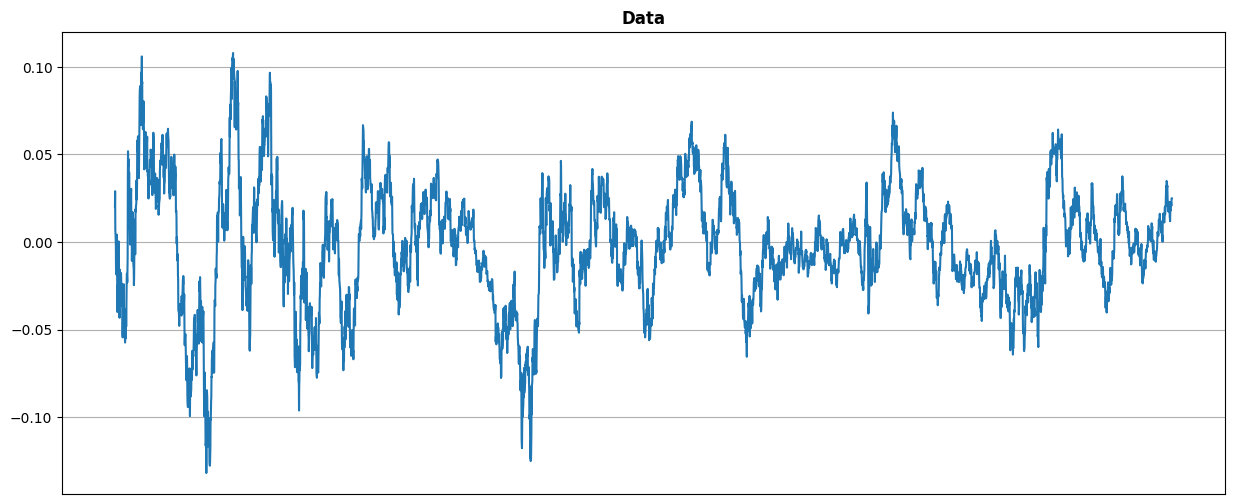

In [4]:
model.plot_data()

In [5]:
model.build()

2024-09-23 12:55:25.600457: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/home/golderalex2/Downloads/statistic/python/deep_learning_forecast/rnn_EURUSD_1d.hdf5